In [ ]:
from IPython.display import clear_output

In [ ]:
# !echo "Downloading 101_Object_Categories for image notebooks"

# !curl -L -o 101_ObjectCategories.zip --progress-bar https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1
# !unzip 101_ObjectCategories.zip
# !mv caltech-101/101_ObjectCategories.tar.gz ./101_ObjectCategories.tar.gz
# !tar -xzf 101_ObjectCategories.tar.gz
# !rm 101_ObjectCategories.tar.gz
# !ls

# clear_output()

In [1]:
import random

import torch
import torch.nn as nn
from torch.utils.data import Subset, DataLoader

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [2]:
to_tensor = transforms.ToTensor()

class GrayScaleToColorTransform:

    def __call__(self, img):
        return to_tensor(img.convert('L')), to_tensor(img)

In [4]:
transform_input = transforms.Compose([
    transforms.Resize((128, 128)),
    GrayScaleToColorTransform()
])

image_dataset = torchvision.datasets.ImageFolder(root=r'C:\Users\trh00\Documents\ML-projects\101_ObjectCategories', transform=transform_input)

In [5]:
(gs_img, rgb_img), _ = image_dataset[0]  # _ is the image class which we don't need for this assignment

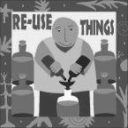

In [6]:
transforms.functional.to_pil_image(gs_img)

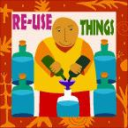

In [7]:
transforms.functional.to_pil_image(rgb_img)

In [8]:
print(len(image_dataset))

9144


# Tasks:

1. Build a custo [AutoEncoder] NN model. The input to the model is the Gray Scale Image and it's output should be colored image.
2. Split the data into training and validation splits (80%, 20%). Train the model on training data.
3. After training, show final loss value as well as draw a plot to show how loss dropped during training (both train and val loss).
4. Manually show the model's performance. Pick 3 random grayscale image, and RGB img pairs from the **val dataset** and for each of the grayscale image, show the grayscale img, the RGB image, and the model output image.

2

In [23]:
# Split the dataset into train and test sets
torch.manual_seed(0)
train_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [int(0.8 * len(image_dataset)), len(image_dataset) - int(0.8 * len(image_dataset))])

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [24]:
for (gs_imgs, rgb_imgs), _ in train_loader:
    print(gs_imgs.shape, rgb_imgs.shape)
    break

torch.Size([32, 1, 128, 128]) torch.Size([32, 3, 128, 128])


In [25]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    """U-Net model with skip connections (Residuals)."""
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        # --- ENCODER ---
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        # --- BOTTLENECK ---
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )
        
        # --- DECODER ---
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),  # 512 + 512 (residual) = 1024 input channels
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),  # 256 + 256 (residual) = 512 input channels
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),  # 128 + 128 (residual) = 256 input channels
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  # 64 + 64 (residual) = 128 input channels
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Final layer
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
        
        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # --- ENCODER ---
        enc1 = self.enc1(x) #  
        enc2 = self.enc2(self.pool(enc1))  # (32x32) -> (16x16)
        enc3 = self.enc3(self.pool(enc2))  # (16x16) -> (8x8) 
        enc4 = self.enc4(self.pool(enc3))  # (8x8)   -> (4x4) 
        
        # --- BOTTLENECK ---
        bottleneck = self.bottleneck(self.pool(enc4))
        
        # --- DECODER + SKIP CONNECTIONS ---
        x = self.up4(bottleneck)
        x = torch.cat([x, enc4], dim=1)
        dec4 = self.dec4(x)
        
        x = self.up3(dec4)
        x = torch.cat([x, enc3], dim=1)
        dec3 = self.dec3(x)
        
        x = self.up2(dec3)
        x = torch.cat([x, enc2], dim=1)
        dec2 = self.dec2(x)
        
        x = self.up1(dec2)
        x = torch.cat([x, enc1], dim=1)
        dec1 = self.dec1(x)
        
        # --- FINAL LAYER ---
        return self.final(dec1)


In [32]:
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for (images, target), _ in tqdm(dataloader):
        images, target = images.to(device), target.to(device).squeeze(dim=1).to(torch.float)  # mask shape becomes [N, H, W]
        
        outputs = model(images)  
        # print(outputs.shape)
        # print(target.shape)
        
        loss = criterion(outputs, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

# 🔹 Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    # print(-1)
    with torch.no_grad():
        for (images, target), _ in dataloader:
            # print(0)
            images, target = images.to(device), target.to(device).to(torch.long)    
            # print(1)
            outputs = model(images)  
            # print(2)
            loss = criterion(outputs, target)
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [33]:
import torch

# Initialize model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet(in_channels=1, out_channels=3).to(device)  # Output channels = 3 classes 

In [34]:

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

num_epochs = 10  # Define number of epochs
train_losses = []
val_losses = []

# Training Loop
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, validation_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


100%|██████████| 229/229 [14:23<00:00,  3.77s/it]


Epoch 1/10: Train Loss = 0.0780, Val Loss = 0.2540


100%|██████████| 229/229 [14:20<00:00,  3.76s/it]


Epoch 2/10: Train Loss = 0.0103, Val Loss = 0.2665


100%|██████████| 229/229 [14:05<00:00,  3.69s/it]


Epoch 3/10: Train Loss = 0.0094, Val Loss = 0.2909


100%|██████████| 229/229 [13:56<00:00,  3.65s/it]


Epoch 4/10: Train Loss = 0.0089, Val Loss = 0.2775


100%|██████████| 229/229 [14:03<00:00,  3.68s/it]


Epoch 5/10: Train Loss = 0.0084, Val Loss = 0.2829


100%|██████████| 229/229 [13:55<00:00,  3.65s/it]


Epoch 6/10: Train Loss = 0.0082, Val Loss = 0.2663


100%|██████████| 229/229 [14:17<00:00,  3.75s/it]


Epoch 7/10: Train Loss = 0.0078, Val Loss = 0.2858


100%|██████████| 229/229 [13:59<00:00,  3.67s/it]


Epoch 8/10: Train Loss = 0.0078, Val Loss = 0.2843


100%|██████████| 229/229 [13:55<00:00,  3.65s/it]


Epoch 9/10: Train Loss = 0.0077, Val Loss = 0.2705


100%|██████████| 229/229 [14:01<00:00,  3.67s/it]


Epoch 10/10: Train Loss = 0.0075, Val Loss = 0.2769


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


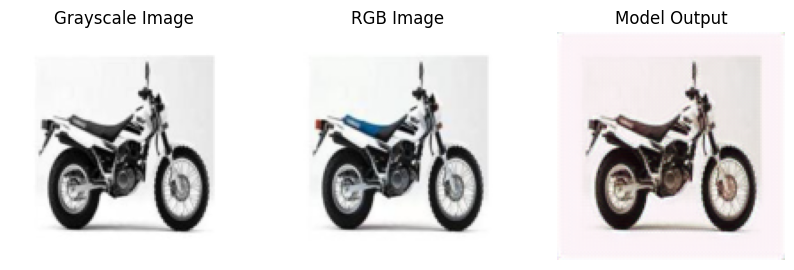

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


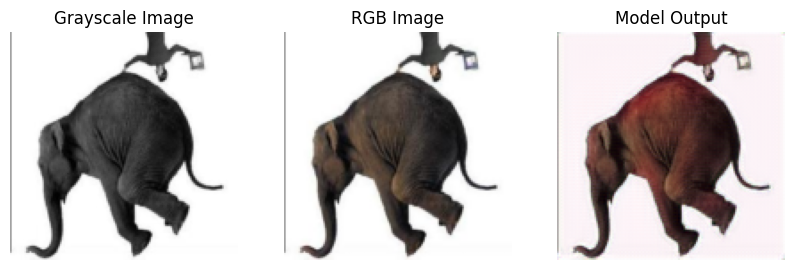

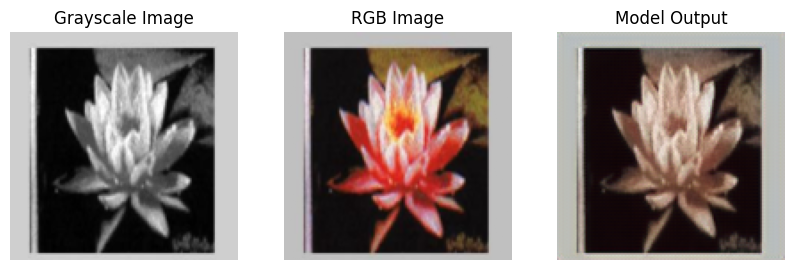

In [35]:
#4. Manually show the model's performance. Pick 3 random grayscale image, and RGB img pairs from the **val dataset** and for each of the grayscale image, show the grayscale img, the RGB image, and the model output image.

import random

# Set model to evaluation mode
model.eval()

# Pick 3 random images from the validation set
random.seed(0)
random_indices = random.sample(range(len(validation_loader.dataset)), 3)

for idx in random_indices:
    (gs_img, rgb_img), _ = validation_loader.dataset[idx]
    gs_img, rgb_img = gs_img.unsqueeze(dim=0).to(device), rgb_img.unsqueeze(dim=0).to(device)
    output_img = model(gs_img).detach().cpu()

    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(gs_img.squeeze(dim=0).squeeze(dim=0).detach().cpu(), cmap='gray')
    ax[0].set_title('Grayscale Image')
    ax[0].axis('off')

    ax[1].imshow(rgb_img.squeeze(dim=0).permute(1, 2, 0).detach().cpu())
    ax[1].set_title('RGB Image')
    ax[1].axis('off')

    ax[2].imshow(output_img.squeeze(dim=0).permute(1, 2, 0).detach().cpu())
    ax[2].set_title('Model Output')
    ax[2].axis('off')

    plt.show()